# Shape and Morphology Analysis

# Section 1: Importing libraries and image

In [7]:
# Import libraries
from plantcv import plantcv as pcv 

In [8]:
class options:
    def __init__(self):
        self.image = "side_view_plant_img.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "side_view_morphology_analysis.txt"
        self.outdir = "."

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


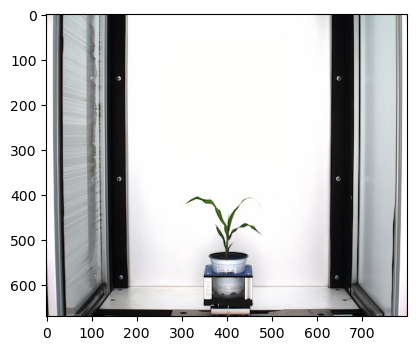

In [9]:
# Read image (sometimes you need to run this line twice to see the image) 

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

# Section 2: Isolating plant, making binary mask, getting object(s)
* Requires successful import of image
* See Isolating Plant Material Tutorial for a full list of functions  that can be used to create a binary mask

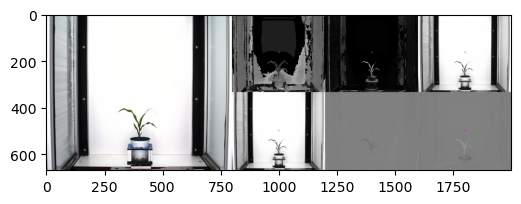

In [10]:
colorspaces = pcv.visualize.colorspaces(rgb_img=img)

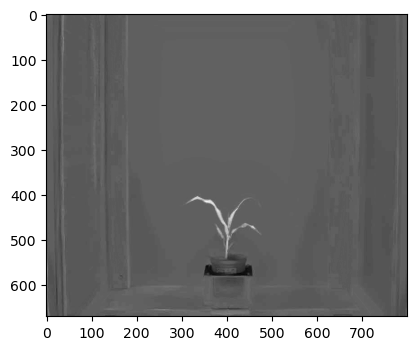

In [11]:
b = pcv.rgb2gray_lab(rgb_img=img, channel="b")

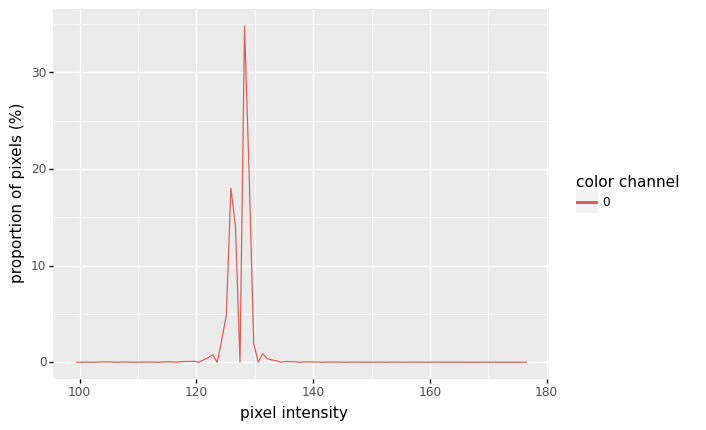

In [12]:
hist = pcv.visualize.histogram(img=b)

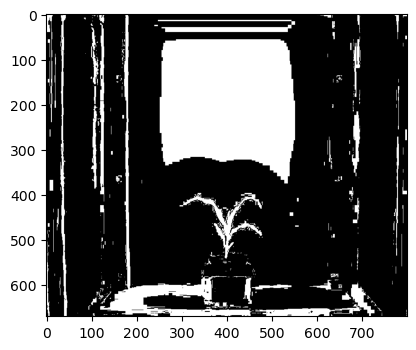

In [13]:
s_thresh = pcv.threshold.binary(gray_img = b, threshold = 128, max_value = 255, object_type = 'light')

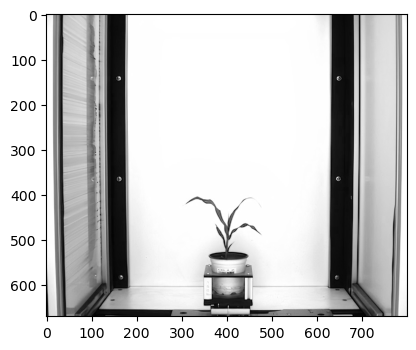

In [14]:
v = pcv.rgb2gray_hsv(rgb_img = img, channel = 'v')

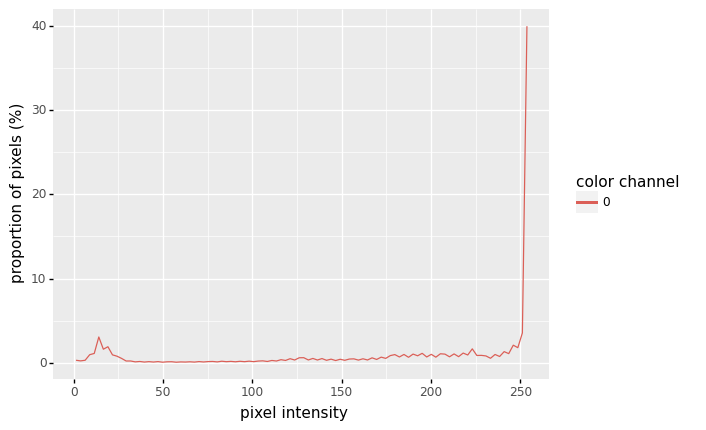

In [15]:
hist2 = pcv.visualize.histogram(img=v)

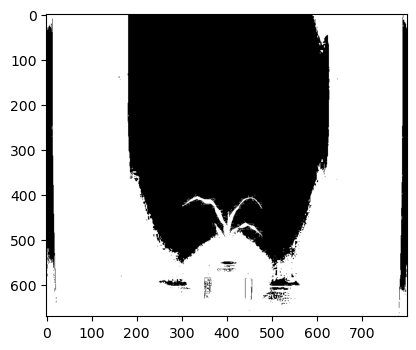

In [16]:
v_thresh = pcv.threshold.binary(gray_img = v, threshold = 250, max_value = 255, object_type = 'dark')

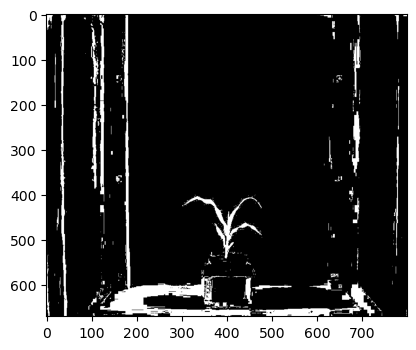

In [17]:
mask = pcv.logical_and(bin_img1 = s_thresh, bin_img2 = v_thresh)

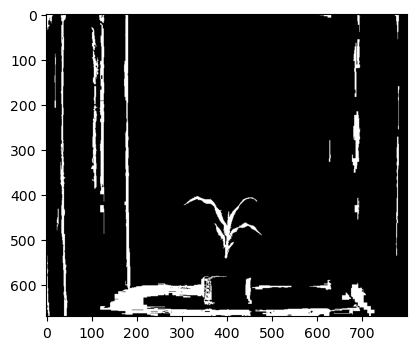

In [18]:
s_fill = pcv.fill(bin_img = mask, size = 100)

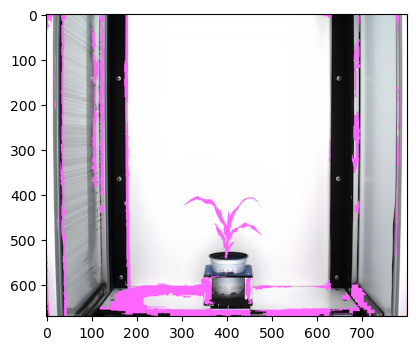

In [19]:
obj, obj_hierarchy = pcv.find_objects(img=img, mask=s_fill)

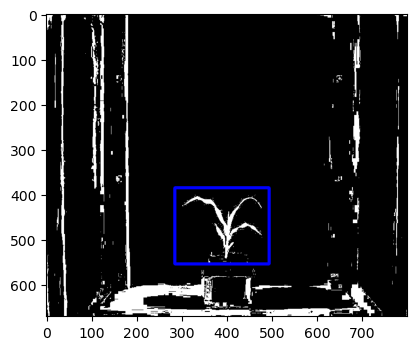

In [20]:
roi1, roi_hierarchy= pcv.roi.rectangle(img=mask, x=285, y=385, h=170, w=210)

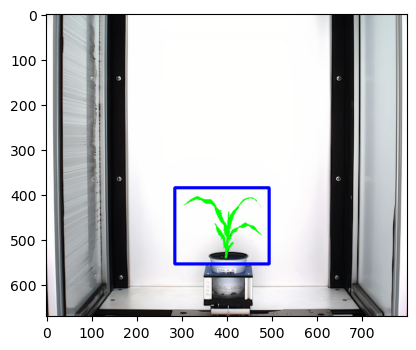

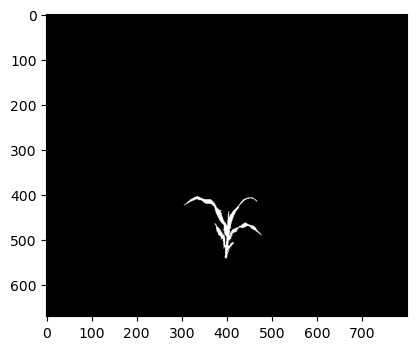

In [21]:
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                                   roi_hierarchy=roi_hierarchy, 
                                                                   object_contour=obj, 
                                                                   obj_hierarchy=obj_hierarchy,
                                                                   roi_type='partial')

In [22]:
cropped_mask = kept_mask[380:550, 280:500]

# Section 3: Morphology analysis

* Requires plant image and completed binary mask

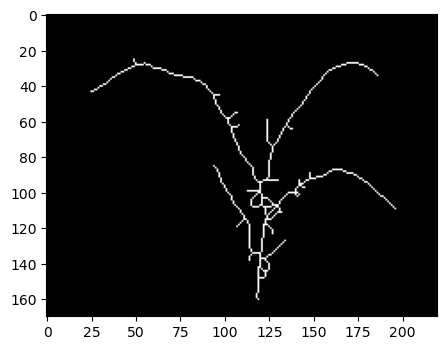

In [23]:
skeleton = pcv.morphology.skeletonize(mask=cropped_mask)

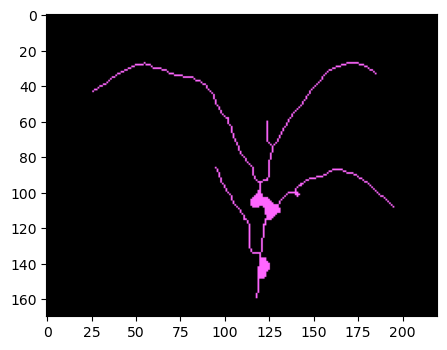

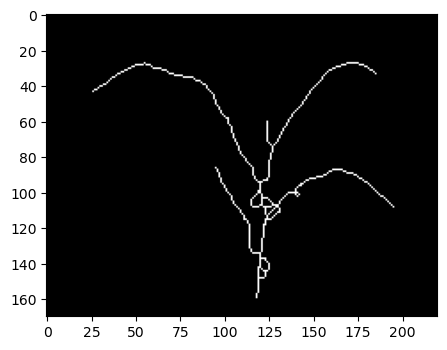

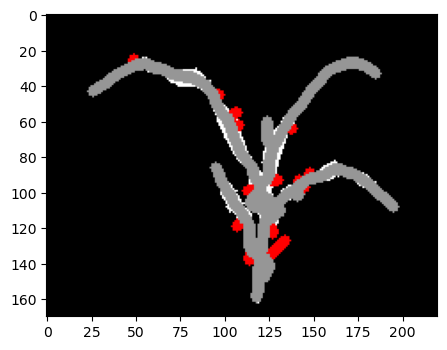

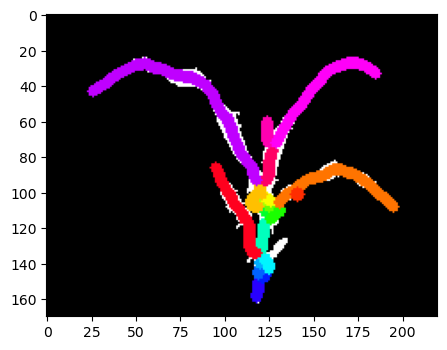

In [24]:
# Prune the skeleton  
# Generally, skeletonized images will have barbs (this image is particularly ideal, 
# that's why it's the example image in the tutorial!), 
# representing the width, that need to get pruned off. 

# Inputs:
#   skel_img = Skeletonized image
#   size     = Size to get pruned off each branch
#   mask     = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.
img1, seg_img, edge_objects = pcv.morphology.prune(skel_img=skeleton, size=20, mask=cropped_mask)

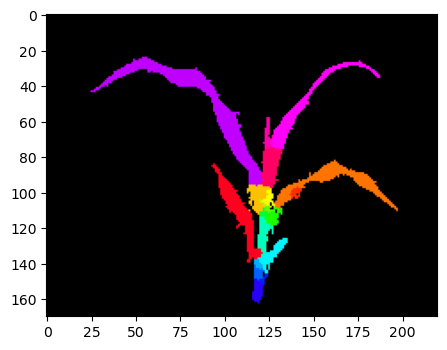

In [25]:
# Fill in segments (also stores out area data)  

# Inputs:
#   mask    = Binary image, single channel, object = 1 and background = 0
#   objects = List of contours
#   label   = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects, label="default")

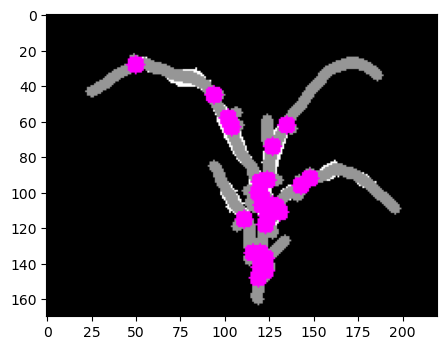

In [26]:
# Identify branch points   

# Inputs:
#   skel_img = Skeletonized image
#   mask     = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.
#   label    = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)
branch_pts_mask = pcv.morphology.find_branch_pts(skel_img=skeleton, mask=cropped_mask, label="default")

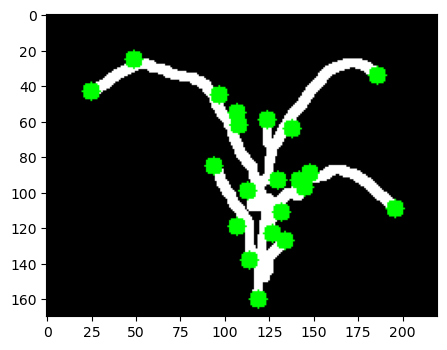

In [27]:
# Identify tip points   

# Inputs:
#   skel_img = Skeletonized image
#   mask     = (Optional) binary mask for debugging. If provided, debug 
#              image will be overlaid on the mask
#   label    = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

tip_pts_mask = pcv.morphology.find_tips(skel_img=skeleton, mask=None, label="default")

In [28]:
# Adjust line thickness with the global line thickness parameter (default = 5),
# and provide binary mask of the plant for debugging. NOTE: the objects and
# hierarchies returned will be exactly the same but the debugging image (segmented_img)
# will look different.
pcv.params.line_thickness = 2


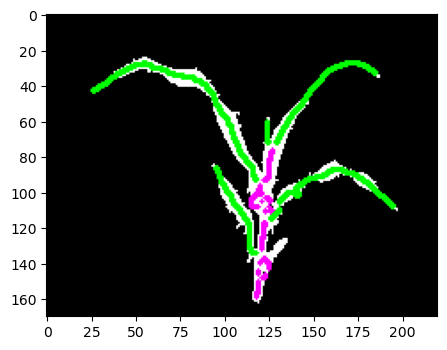

In [29]:
# Sort segments into primary (stem) objects and secondary (leaf) objects. 
# Downstream steps can be performed on just one class of objects at a time, 
# or all objects (output from segment_skeleton) 
  
# Inputs:
#   skel_img = Skeletonized image
#   objects  = List of contours
#   mask     = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.
leaf_obj, stem_obj = pcv.morphology.segment_sort(skel_img=skeleton, 
                                                 objects=edge_objects,
                                                 mask=cropped_mask)

In [30]:
# Resulting image text can be altered by changing the size of pcv.params.text_size
# (default = .55) and pcv.params.text_thickness (default = 3)
pcv.params.text_size = .4
pcv.params.text_thickness = 1

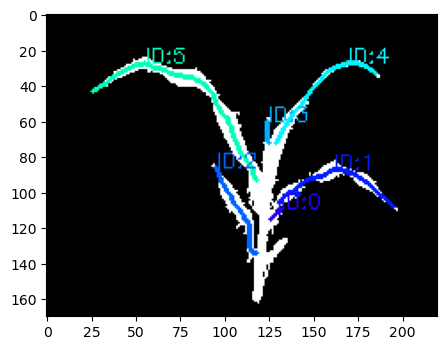

In [31]:
# Identify segments     

# Inputs:
#   skel_img  = Skeletonized image
#   objects   = List of contours
#   mask      = (Optional) binary mask for debugging. If provided, 
#               debug image will be overlaid on the mask.
segmented_img, labeled_img = pcv.morphology.segment_id(skel_img=skeleton,
                                                       objects=leaf_obj,
                                                       mask=cropped_mask)

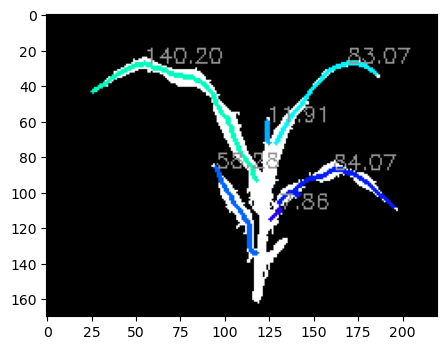

In [32]:
# Measure path lengths of segments     

# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours
#   label         = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)
labeled_img  = pcv.morphology.segment_path_length(segmented_img=segmented_img, 
                                                  objects=leaf_obj, label="default")



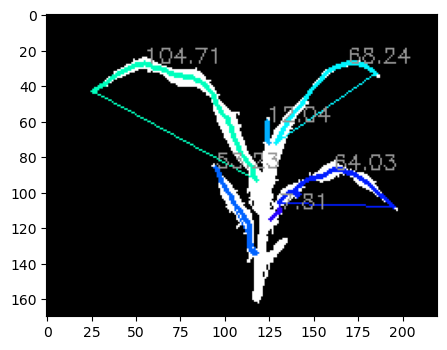

In [33]:
# Measure euclidean distance of segments      

# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours
#   label         = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)
labeled_img = pcv.morphology.segment_euclidean_length(segmented_img=segmented_img, 
                                                      objects=leaf_obj, label="default")

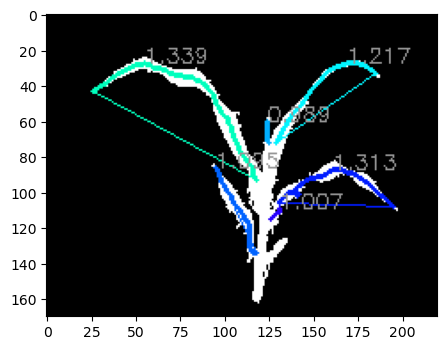

In [34]:
# Measure curvature of segments      

# Inputs:
#   segmented_img = Segmented image to plot curvature on
#   objects       = List of contours
#   label         = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)
labeled_img = pcv.morphology.segment_curvature(segmented_img=segmented_img, 
                                               objects=leaf_obj, label="default")

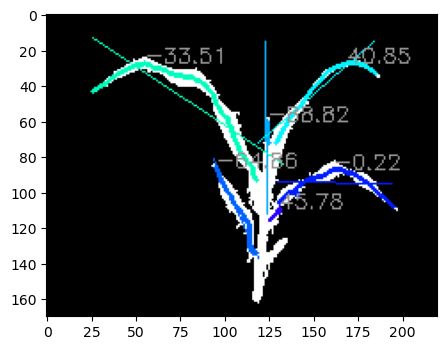

In [35]:
# Measure the angle of segments      

# Inputs:
#   segmented_img = Segmented image to plot angles on
#   objects       = List of contours
#   label         = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)
labeled_img = pcv.morphology.segment_angle(segmented_img=segmented_img, 
                                           objects=leaf_obj, label="default")

Size too large, contour with ID# 0 got pruned away completely.
Slope of contour with ID# 3 is [22877334.] and cannot be plotted.


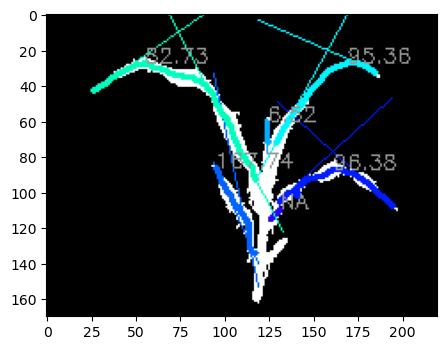

In [36]:
# Measure the tangent angles of segments      

# Inputs:
#   segmented_img = Segmented image to plot tangent angles on
#   objects       = List of contours
#   size          = Size of ends used to calculate "tangent" lines
#   label         = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)
labeled_img = pcv.morphology.segment_tangent_angle(segmented_img=segmented_img, 
                                                   objects=leaf_obj, size=15, label="default")

Size too large, contour with ID# 0 got pruned away completely.


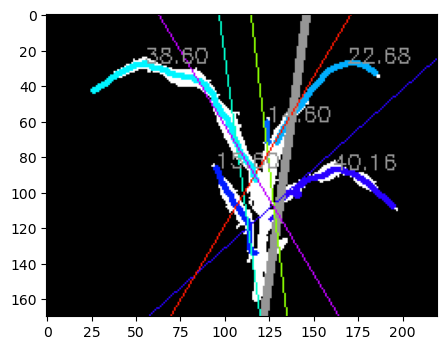

In [37]:
# Measure the leaf insertion angles      

# Inputs:
#   skel_img         = Skeletonize image 
#   segmented_img    = Segmented image to plot insertion angles on
#   leaf_objects     = List of leaf contours
#   stem_objects     = List of stem objects 
#   size             = Size of the inner portion of each leaf to find a linear regression line
#   label            = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

labeled_img = pcv.morphology.segment_insertion_angle(skel_img=skeleton,
                                                     segmented_img=segmented_img, 
                                                     leaf_objects=leaf_obj, 
                                                     stem_objects=stem_obj,
                                                     size=20, label="default")

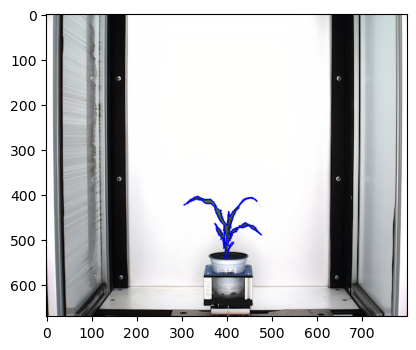

In [38]:
# Combine objects together in each plant     

# Inputs:
#   img                = image
#   contours           = filtered plant contours from the roi_objects function
#   filtered_hierarchy = filtered plant contour hierarchy from the roi_objects function
plant_contour, plant_mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy3)

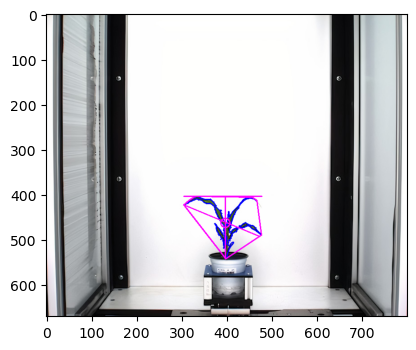

In [39]:
# Find shape properties, output shape image (optional)

# Inputs:
#   img - RGB or grayscale image data 
#   obj- Single or grouped contour object
#   mask - Binary image mask to use as mask for moments analysis  
#   label - Optional label parameter, modifies the variable name of observations recorded   
shape_img = pcv.analyze_object(img=img, obj=plant_contour, mask=plant_mask, label="default")

In [40]:
# Write morphological data to results file

# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
pcv.outputs.save_results(filename=args.result)